In [1]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2
import sqlalchemy
import os
import json
import uuid


In [2]:
conn = psycopg2.connect(
    user="dcat", 
    password="dcat", 
    host="127.0.0.1", 
    port="54320", 
    database="dcat")

OperationalError: could not connect to server: Connection refused
	Is the server running on host "127.0.0.1" and accepting
	TCP/IP connections on port 54320?


In [413]:
conn = psycopg2.connect(
    user="v-oidc-Pau-data-cat-JttunzZohPHCVqCALH7e-1574349384", 
    password="A1a-KVbk7te3wn4ndtue", 
    host="A01DBVL010.adeo.no", 
    port="5432", 
    database="data-catalog-metadata")

In [3]:
conn.commit()

conn.commit()
node = {"id":"test"}
js = json.dumps(node)
statement = f"insert into tbl_node (prop) values ('{js}')"
cur.execute(statement)
conn.commit()

In [4]:
cur = conn.cursor()

In [5]:
print ( conn.get_dsn_parameters(),"\n")

{'user': 'dcat', 'dbname': 'dcat', 'host': '127.0.0.1', 'port': '54320', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 



In [6]:
cur.execute("SELECT version();")
record = cur.fetchone()
print("You are connected to - ", record,"\n")

You are connected to -  ('PostgreSQL 12.0 (Debian 12.0-1.pgdg100+1) on x86_64-pc-linux-gnu, compiled by gcc (Debian 8.3.0-6) 8.3.0, 64-bit',) 



# Init

In [7]:
#Relationship description/attributes
cur.execute("delete from tbl_edge_desc")
#Relationships/Edges
cur.execute("delete from tbl_edge")
#Node details table
cur.execute("delete from tbl_node")

conn.commit()

# Get data

In [8]:
xls = pd.ExcelFile("../data/testdata.xlsx")
xls.sheet_names

['Formål GML',
 'Formål',
 'Ark1',
 'data-catalog-backend',
 'data-catalog-policies',
 'Category']

# Populate tables

In [9]:
def get_id(row):
    return row['type'] + '.' + row['name'].upper()

def get_uuid(row):
    return row['type'] + '.' + str(uuid.uuid4()).upper()

### Relationships

In [10]:
relationships = ["has purpose", "based on purpose", "has attribute", "attribute of","belongs to category", "contains concept"]
index = 1
for relationship in relationships:
    insert_query = f"insert into tbl_edge_desc values ({index},'{relationship}')"
    cur.execute(insert_query)
    index += 1
    
conn.commit()

In [11]:
df_links = sqlio.read_sql_query("select * from tbl_edge_desc", conn)
df_links

,id,prop
0,1,has purpose
1,2,based on purpose
2,3,has attribute
3,4,attribute of
4,5,belongs to category
5,6,contains concept


### Processing activities

In [12]:
sheet=xls.sheet_names[1]
df_formål = pd.read_excel(xls, sheet, encoding='latin1')
df_formål = df_formål[['Forslag til endelig formålskode', 'Formålsbeskrivelse']]
df_formål.columns=['code', 'description']
df_formål['name'] = df_formål['code'].apply(lambda x: x.upper())
df_formål = df_formål.append({'name': 'NOT AVAILABLE', 'description': 'Not Available -Verdi mangler'}, ignore_index=True)
df_formål.drop(['code'], axis=1, inplace=True)
df_formål['label'] = 'Processing activity'
df_formål['type'] = 'GDPR.PROCESSING_ACTIVITY'
df_formål['id'] = df_formål.apply(get_id, axis=1)
df_formål.tail()

,description,name,label,type,id
33,Behandle og vurdere rett til uføretrygd som sk...,UFØRETRYGD,Processing activity,GDPR.PROCESSING_ACTIVITY,GDPR.PROCESSING_ACTIVITY.UFØRETRYGD
34,Behandle og vurdere rett til ventelønn som ska...,VENTELØNN,Processing activity,GDPR.PROCESSING_ACTIVITY,GDPR.PROCESSING_ACTIVITY.VENTELØNN
35,Behandle og vurdere rett til ytelser ved yrkes...,YRKESSKADE- OG SYKDOM,Processing activity,GDPR.PROCESSING_ACTIVITY,GDPR.PROCESSING_ACTIVITY.YRKESSKADE- OG SYKDOM
36,Behandle og vurdere rett til ytelser til famil...,YTELSER TIL FAMILIEPLEIER,Processing activity,GDPR.PROCESSING_ACTIVITY,GDPR.PROCESSING_ACTIVITY.YTELSER TIL FAMILIEPL...
37,Not Available -Verdi mangler,NOT AVAILABLE,Processing activity,GDPR.PROCESSING_ACTIVITY,GDPR.PROCESSING_ACTIVITY.NOT AVAILABLE


In [13]:
for index, row in df_formål.iterrows():
    id = index + 1
    jsonb = row.to_json()
    insert_query = f"insert into tbl_node (prop) values ('{jsonb}')"
    cur.execute(insert_query, (jsonb,))
    
conn.commit()

In [14]:
df = sqlio.read_sql_query("select * from tbl_node", conn)
df.tail()

,id,prop,created
33,34,"{'id': 'GDPR.PROCESSING_ACTIVITY.UFØRETRYGD', ...",2019-11-23 12:55:12.127431
34,35,"{'id': 'GDPR.PROCESSING_ACTIVITY.VENTELØNN', '...",2019-11-23 12:55:12.127431
35,36,{'id': 'GDPR.PROCESSING_ACTIVITY.YRKESSKADE- O...,2019-11-23 12:55:12.127431
36,37,{'id': 'GDPR.PROCESSING_ACTIVITY.YTELSER TIL F...,2019-11-23 12:55:12.127431
37,38,{'id': 'GDPR.PROCESSING_ACTIVITY.NOT AVAILABLE...,2019-11-23 12:55:12.127431


### Purpose

In [15]:
df_purpose = df_formål.copy()
df_purpose['type'] = 'GDPR.PURPOSE'
df_purpose['label'] = 'Purpose'
df_purpose['id'] = df_purpose.apply(get_id, axis=1)

In [16]:
for i, row in df_purpose.iterrows():
    jsonb = row.to_json()
    insert_query = f"insert into tbl_node (prop) values ('{jsonb}')"
    cur.execute(insert_query, (jsonb,))
    
conn.commit()

In [17]:
df = sqlio.read_sql_query("select * from tbl_node", conn)
df.tail()

,id,prop,created
71,72,"{'id': 'GDPR.PURPOSE.UFØRETRYGD', 'name': 'UFØ...",2019-11-23 12:55:18.265661
72,73,"{'id': 'GDPR.PURPOSE.VENTELØNN', 'name': 'VENT...",2019-11-23 12:55:18.265661
73,74,"{'id': 'GDPR.PURPOSE.YRKESSKADE- OG SYKDOM', '...",2019-11-23 12:55:18.265661
74,75,{'id': 'GDPR.PURPOSE.YTELSER TIL FAMILIEPLEIER...,2019-11-23 12:55:18.265661
75,76,"{'id': 'GDPR.PURPOSE.NOT AVAILABLE', 'name': '...",2019-11-23 12:55:18.265661


### Legal basis

In [18]:
sheet=xls.sheet_names[4]
df_legal_basis = pd.read_excel(xls, sheet, encoding='latin1')
df_legal_basis = df_legal_basis[['legalBasisDescription']].drop_duplicates()
df_legal_basis.columns=['name']
df_legal_basis = df_legal_basis.append({'name': 'NOT AVAILABLE'}, ignore_index=True)
df_legal_basis['type'] = 'GDPR.LEGAL_BASIS'
df_legal_basis['label'] = 'Legal basis'
df_legal_basis['id'] = df_legal_basis.apply(get_uuid, axis=1)
df_legal_basis.head()

,name,type,label,id
0,Ftrl. § 11-20,GDPR.LEGAL_BASIS,Legal basis,GDPR.LEGAL_BASIS.F8D345F9-6A7C-4CCE-84B4-6C3CC...
1,"Ftrl. §§ 3-16, 3-24, 3-25, 20-8.",GDPR.LEGAL_BASIS,Legal basis,GDPR.LEGAL_BASIS.45286FB7-B10D-4AC7-A124-F44D1...
2,"Kapittel 3, 19, 20 0g 22",GDPR.LEGAL_BASIS,Legal basis,GDPR.LEGAL_BASIS.F0AA09C0-E091-4113-A429-8FE8E...
3,Ftrl § 3-2 og § 3-3,GDPR.LEGAL_BASIS,Legal basis,GDPR.LEGAL_BASIS.CC426220-EB5E-4E84-962F-79024...
4,Barnetrygdloven § 9,GDPR.LEGAL_BASIS,Legal basis,GDPR.LEGAL_BASIS.0D99D1FF-D4EE-4AC6-864B-26C5E...


In [19]:
for i, row in df_legal_basis.iterrows():
    index = index + 1
    jsonb = row.to_json()
    insert_query = f"insert into tbl_node (prop) values ('{jsonb}')"
    cur.execute(insert_query, (jsonb,))
    
conn.commit()

In [20]:
df = sqlio.read_sql_query("select * from tbl_node", conn)
df.tail()

,id,prop,created
232,233,{'id': 'GDPR.LEGAL_BASIS.BC728E5F-9666-4F12-86...,2019-11-23 12:55:21.394550
233,234,{'id': 'GDPR.LEGAL_BASIS.69172F77-5376-4888-89...,2019-11-23 12:55:21.394550
234,235,{'id': 'GDPR.LEGAL_BASIS.ECBF7642-5824-4B12-B9...,2019-11-23 12:55:21.394550
235,236,{'id': 'GDPR.LEGAL_BASIS.11549F4B-C8A7-4D1E-80...,2019-11-23 12:55:21.394550
236,237,{'id': 'GDPR.LEGAL_BASIS.DF5E334D-9C7B-415D-B8...,2019-11-23 12:55:21.394550


### Information types

In [21]:
sheet=xls.sheet_names[3]

df_concepts = pd.read_excel(xls, sheet, encoding='latin1')
df_concepts = df_concepts[['title', 'description']]
df_concepts.columns=['name', 'description']
df_concepts['name'] = df_concepts['name'].apply(lambda x: x.strip().upper())
df_concepts = df_concepts.append({'name': 'NOT AVAILABLE', 'description': 'Not Available -Verdi mangler'}, ignore_index=True).drop_duplicates()
df_concepts['label'] = 'Information type'
df_concepts['type'] = 'GDPR.INFORMATION_TYPE'
df_concepts['id'] = df_concepts.apply(get_id, axis=1)
df_concepts.head()

,name,description,label,type,id
0,SIVILSTAND,En overordnet kategori som beskriver en person...,Information type,GDPR.INFORMATION_TYPE,GDPR.INFORMATION_TYPE.SIVILSTAND
1,ARBEIDSFORHOLD,"Avtaleforhold hvor den ene part, arbeidstakere...",Information type,GDPR.INFORMATION_TYPE,GDPR.INFORMATION_TYPE.ARBEIDSFORHOLD
2,KJØNN,TODO - mangler i begrepskatalogen og i MFNs be...,Information type,GDPR.INFORMATION_TYPE,GDPR.INFORMATION_TYPE.KJØNN
3,NAVN,I Norge skal alle ha fornavn og ett enkelt ell...,Information type,GDPR.INFORMATION_TYPE,GDPR.INFORMATION_TYPE.NAVN
4,FØDSELSDATO,Datoen personen er født.,Information type,GDPR.INFORMATION_TYPE,GDPR.INFORMATION_TYPE.FØDSELSDATO


In [22]:
df_concepts.iloc[0]['id']

'GDPR.INFORMATION_TYPE.SIVILSTAND'

In [23]:
for i, row in df_concepts.iterrows():
    jsonb = row.to_json()
    insert_query = f"insert into tbl_node (prop) values ('{jsonb}')"
    cur.execute(insert_query, (jsonb,))
    
conn.commit()

In [24]:
df = sqlio.read_sql_query("select * from tbl_node", conn)
df.tail()

,id,prop,created
253,254,{'id': 'GDPR.INFORMATION_TYPE.FLYKTNINGSTATUS'...,2019-11-23 12:55:24.287384
254,255,"{'id': 'GDPR.INFORMATION_TYPE.FORELDREANSVAR',...",2019-11-23 12:55:24.287384
255,256,{'id': 'GDPR.INFORMATION_TYPE.FORSTERFORELDRE'...,2019-11-23 12:55:24.287384
256,257,"{'id': 'GDPR.INFORMATION_TYPE.FULLMAKT', 'name...",2019-11-23 12:55:24.287384
257,258,"{'id': 'GDPR.INFORMATION_TYPE.NOT AVAILABLE', ...",2019-11-23 12:55:24.287384


### Categories

In [25]:
sheet=xls.sheet_names[3]
df_categories = pd.read_excel(xls, sheet, encoding='latin1')
df_categories = df_categories[['categories']]
df_categories.columns=['name']
df_categories['name'] = df_categories['name'].apply(lambda x: x.strip().upper())
df_categories = df_categories.append({'name': 'NOT AVAILABLE'}, ignore_index=True).drop_duplicates()
df_categories['label'] = 'Information type category'
df_categories['type'] = 'GDPR.INFORMATION_TYPE_CATEGORY'
df_categories['id'] = df_categories.apply(get_id, axis=1)
df_categories.head()

,name,label,type,id
0,PERSONALIA,Information type category,GDPR.INFORMATION_TYPE_CATEGORY,GDPR.INFORMATION_TYPE_CATEGORY.PERSONALIA
1,ARBEIDSFORHOLD,Information type category,GDPR.INFORMATION_TYPE_CATEGORY,GDPR.INFORMATION_TYPE_CATEGORY.ARBEIDSFORHOLD
6,KONTAKTOPPLYSNINGER,Information type category,GDPR.INFORMATION_TYPE_CATEGORY,GDPR.INFORMATION_TYPE_CATEGORY.KONTAKTOPPLYSNI...
9,FAMILIERELASJONER,Information type category,GDPR.INFORMATION_TYPE_CATEGORY,GDPR.INFORMATION_TYPE_CATEGORY.FAMILIERELASJONER
16,FOLKETRYGD,Information type category,GDPR.INFORMATION_TYPE_CATEGORY,GDPR.INFORMATION_TYPE_CATEGORY.FOLKETRYGD


In [26]:
for i, row in df_categories.iterrows():
    index = index + 1
    jsonb = row.to_json()
    insert_query = f"insert into tbl_node (prop) values ('{jsonb}')"
    cur.execute(insert_query, (jsonb,))
    
conn.commit()

### Nodes

In [27]:
df_nodes = sqlio.read_sql_query("select * from tbl_node", conn)
df_nodes['name'] = df_nodes['prop'].apply(lambda x : x['name'])
df_nodes['type'] = df_nodes['prop'].apply(lambda x : x['type'])
df_nodes.head()

,id,prop,created,name,type
0,1,{'id': 'GDPR.PROCESSING_ACTIVITY.ALDERSPENSJON...,2019-11-23 12:55:12.127431,ALDERSPENSJON,GDPR.PROCESSING_ACTIVITY
1,2,{'id': 'GDPR.PROCESSING_ACTIVITY.ARBEIDSAVKLAR...,2019-11-23 12:55:12.127431,ARBEIDSAVKLARINGSPENGER (AAP),GDPR.PROCESSING_ACTIVITY
2,3,{'id': 'GDPR.PROCESSING_ACTIVITY.AVTALEFESTET ...,2019-11-23 12:55:12.127431,AVTALEFESTET PENSJON (AFP) FOR PRIVAT SEKTOR,GDPR.PROCESSING_ACTIVITY
3,4,{'id': 'GDPR.PROCESSING_ACTIVITY.AVTALEFESTET ...,2019-11-23 12:55:12.127431,AVTALEFESTET PENSJON (AFP) FOR STATLIG OG KOMM...,GDPR.PROCESSING_ACTIVITY
4,5,"{'id': 'GDPR.PROCESSING_ACTIVITY.BARNEBIDRAG',...",2019-11-23 12:55:12.127431,BARNEBIDRAG,GDPR.PROCESSING_ACTIVITY


### Edges

In [28]:
sheet=xls.sheet_names[3]
df_edges = pd.read_excel(xls, sheet, encoding='latin1')
df_edges = df_edges[['title', 'categories']].drop_duplicates()
df_edges.columns = ['source', 'target']
df_edges['source'] = df_edges['source'].apply(lambda x: x.strip().upper())
df_edges['target'] = df_edges['target'].apply(lambda x: x.strip().upper())
df_edges.drop_duplicates()

df_edges.head()

,source,target
0,SIVILSTAND,PERSONALIA
1,ARBEIDSFORHOLD,ARBEIDSFORHOLD
2,KJØNN,PERSONALIA
3,NAVN,PERSONALIA
4,FØDSELSDATO,PERSONALIA


In [29]:
conn.commit()

In [31]:
cur.execute("delete from tbl_edge")
conn.commit()

for index, row in df_edges.iterrows():
    df_nodes.loc[((df_nodes['name'] == row['source']) & (df_nodes['type'] == 'GDPR.INFORMATION_TYPE')), 'id']
    source_id = df_nodes.loc[((df_nodes['name'] == row['source']) & (df_nodes['type'] == 'GDPR.INFORMATION_TYPE')), 'id'].item()
    target_id = df_nodes.loc[((df_nodes['name'] == row['target']) & (df_nodes['type'] == 'GDPR.INFORMATION_TYPE_CATEGORY')), 'id'].item()
    cur.execute(f"insert into tbl_edge (n1,n2,prop) values ({source_id},{target_id},array[5]);")
    
conn.commit()

In [32]:
df_edges = pd.read_excel(xls, sheet, encoding='latin1')
df_edges = df_edges[['categories', 'title']].drop_duplicates()
df_edges.columns = ['source', 'target']
df_edges['source'] = df_edges['source'].apply(lambda x: x.strip().upper())
df_edges['target'] = df_edges['target'].apply(lambda x: x.strip().upper())
df_edges.drop_duplicates()

df_edges.head()

,source,target
0,PERSONALIA,SIVILSTAND
1,ARBEIDSFORHOLD,ARBEIDSFORHOLD
2,PERSONALIA,KJØNN
3,PERSONALIA,NAVN
4,PERSONALIA,FØDSELSDATO


In [33]:
for index, row in df_edges.iterrows():
    df_nodes.loc[((df_nodes['name'] == row['source']) & (df_nodes['type'] == 'GDPR.INFORMATION_TYPE')), 'id']
    source_id = df_nodes.loc[((df_nodes['name'] == row['source']) & (df_nodes['type'] == 'GDPR.INFORMATION_TYPE_CATEGORY')), 'id'].item()
    target_id = df_nodes.loc[((df_nodes['name'] == row['target']) & (df_nodes['type'] == 'GDPR.INFORMATION_TYPE')), 'id'].item()
    cur.execute(f"insert into tbl_edge (n1,n2,prop) values ({source_id},{target_id},array[6]);")
    
conn.commit()


In [34]:
sql = "select * from tbl_edge"
df = sqlio.read_sql_query(sql, conn)
df.head()

,n1,n2,prop,created
0,238,259,[5],2019-11-23 12:56:03.937181
1,239,260,[5],2019-11-23 12:56:03.937181
2,240,259,[5],2019-11-23 12:56:03.937181
3,241,259,[5],2019-11-23 12:56:03.937181
4,242,259,[5],2019-11-23 12:56:03.937181


In [35]:
conn.commit()

In [36]:
cur.execute("DROP FUNCTION graph_search1(integer,integer,bigint)")

In [37]:
sql = """
create or replace function graph_search1(      
  IN i_root int,                       -- The node that the search is based on        
  IN i_depth int  default 99999,       -- the tier to search (the depth limit)      
  IN i_limit int8 default 2000000000,  -- limit the number of records returned for each tier      
  OUT o_path int[],                    -- output: path, an array of IDs      
  OUT o_point1 int,                    -- output: point 1 ID      
  OUT o_point2 int,                    -- output: point 2 ID      
  OUT o_link_prop int2[],              -- output: the connection property between the two current points      
  OUT o_link_prop_all text,            -- output: the connection property from the starting node to the current node      
  OUT o_depth int                      -- output: current depth (tier)      
) returns setof record as 
$$
      
declare      
  sql text;      
begin      
sql := format($_$      
WITH RECURSIVE search_graph(        
  n1,     -- point 1        
  n2,     -- point 2        
  prop,   -- current edge property      
  all_prop,  -- properties of all edges  
  depth,  -- current depth, starting from 1         
  path    -- path, stored as an array         
) AS (        
        select n1,n2,prop,all_prop,depth,path from (        
        SELECT                               -- ROOT node query        
          g.n1,                              -- point 1        
          g.n2,                              -- point 2        
          g.prop,                            -- edge property        
      g.prop::text as all_prop,          -- properties of all edges  
          1 depth,                           -- initial depth=1        
          ARRAY[g.n1, g.n2] path             -- initial path        
        FROM tbl_edge AS g         
        WHERE         
          n1 = %s                            -- ROOT node=?        
          limit %s                           -- How many records are limited at each tier?        
        ) t        
      UNION ALL        
        select n1,n2,prop,all_prop,depth,path from (        
        SELECT                               -- recursive clause         
          g.n1,                              -- point 1        
          g.n2,                              -- point 2        
          g.prop,                            -- edge property     
      sg.all_prop || g.prop::text as all_prop,    -- properties of all edges  
          sg.depth + 1 depth,                   -- depth +1        
          sg.path || g.n2 path                 -- Add a new point to the path        
        FROM tbl_edge AS g, search_graph AS sg    -- circular INNER JOIN        
        WHERE         
          g.n1 = sg.n2                       -- recursive JOIN condition        
          AND (g.n2 <> ALL(sg.path))                      -- Prevent loop, determine whether it is a loop and judge if the new point is already in the previous path   
          AND sg.depth <= %s                 -- search depth =?          
          limit %s                           -- How many records are limited at each tier?       
        ) t        
)        
SELECT path as o_path, n1 as o_point1, n2 as o_point2, prop as o_link_prop, all_prop as o_link_prop_all, depth as o_depth      
FROM search_graph;                           -- query a recursive table. You can add LIMIT output or use a cursor       
$_$, i_root, i_limit, i_depth, i_limit      
);      
      
return query execute sql;      
      
end;      

$$
 language plpgsql strict;   
"""

cur.execute(sql)

In [38]:
conn.commit()

In [39]:
%%time
sql = "select * from graph_search1(259)"
df = sqlio.read_sql_query(sql, conn)

CPU times: user 2.14 ms, sys: 1.61 ms, total: 3.75 ms
Wall time: 18.1 ms


In [40]:
sql = "select * from graph_search1(259)"
df = sqlio.read_sql_query(sql, conn)

In [41]:
df

,o_path,o_point1,o_point2,o_link_prop,o_link_prop_all,o_depth
0,"[259, 238]",259,238,[6],{6},1
1,"[259, 240]",259,240,[6],{6},1
2,"[259, 241]",259,241,[6],{6},1
3,"[259, 242]",259,242,[6],{6},1
4,"[259, 243]",259,243,[6],{6},1


In [42]:
df_edgelist=df[['o_point1','o_point2','o_link_prop','o_depth']].copy()
df_edgelist.columns=['source','target','id','weight']
df_edgelist['id'] = df_edgelist['id'].apply(lambda x: x[0])
df_edgelist = pd.merge(df_edgelist, df_links, on='id', how='left')
df_edgelist = pd.merge(df_edgelist, df_nodes[['id', 'name']], left_on='source', right_on='id')
df_edgelist = pd.merge(df_edgelist, df_nodes[['id', 'name']], left_on='target', right_on='id')
df_edgelist = df_edgelist[['prop', 'name_x', 'name_y','id','id_y', 'weight']]
df_edgelist.columns = ['name', 'source', 'target','target_node_id','source_node_id', 'weight']
df_edgelist

,name,source,target,target_node_id,source_node_id,weight
0,contains concept,PERSONALIA,SIVILSTAND,238,259,1
1,contains concept,PERSONALIA,KJØNN,240,259,1
2,contains concept,PERSONALIA,NAVN,241,259,1
3,contains concept,PERSONALIA,FØDSELSDATO,242,259,1
4,contains concept,PERSONALIA,FØDSELSNUMMER,243,259,1


In [43]:
#!pip install nx_altair

In [44]:
import altair as alt
alt.renderers.enable('notebook')
alt.themes.enable('opaque')
import networkx as nx
import nx_altair as nxa
import numpy as np

G = nx.from_pandas_edgelist(df_edgelist, 'source', 'target', ['name','target_node_id','source_node_id','weight'])
pos = nx.spring_layout(G)

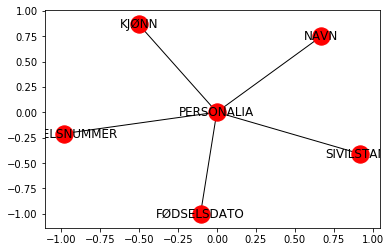

In [47]:
nx.draw_networkx(
    G=G,
    pos=pos
)

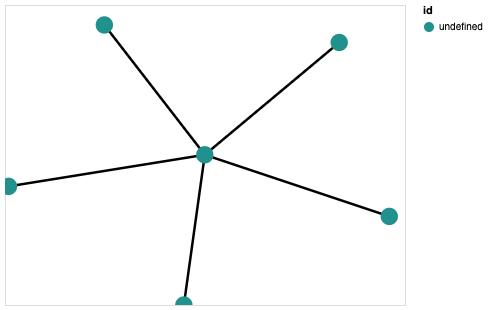

In [46]:
# Compute positions for viz.
pos = nx.spring_layout(G)

viz = nxa.draw_networkx(
    G, pos=pos,
    node_color='id:N',
    cmap='viridis',
    width='weight:N',
    edge_color='black',
    node_tooltip=['weight:N']
)

viz.interactive()

In [11]:
sql = "select * from tbl_node order by created desc"
df = sqlio.read_sql_query(sql, conn)
df.head(20)

,id,prop,created
0,279,"{'id': 'test8', 'type': 'test4'}",2019-11-23 19:36:54.315734
1,278,"{'prop': {'id': 'test7', 'type': 'test4'}}",2019-11-23 19:34:56.101281
2,277,{'type': 'type4'},2019-11-23 19:25:16.867913
3,276,{'id': 'test5'},2019-11-23 19:03:11.549443
4,275,{'id': 'test5'},2019-11-23 19:02:26.394226
5,274,{'id': 'test5'},2019-11-23 18:57:13.467042
6,273,{'id': 'test5'},2019-11-23 18:57:01.679727
7,272,{'id': 'test5'},2019-11-23 18:56:36.923981
8,271,{'id': 'test5'},2019-11-23 18:56:02.849963
9,270,{'type': 'type14'},2019-11-23 18:52:00.236959


In [62]:
conn.commit()

In [97]:
inp = {"id": "test3"}
jsonb = json.dumps(inp)
insert_query = f"insert into tbl_node (prop) values ('{jsonb}')"
cur.execute(insert_query, (jsonb,))
    
conn.commit()

In [98]:
sql = "SELECT * FROM tbl_node WHERE prop->>'id' = 'test3'"
df = sqlio.read_sql_query(sql, conn)
df

,id,prop,created
0,268,{'id': 'test3'},2019-11-23 18:42:36.847657


In [125]:
inp = {
  "prop": {"id":"test0","type": "test"}
}

jsonb = json.dumps(inp['prop'])
insert_query = f"insert into tbl_node (prop) values ('{jsonb}')"
cur.execute(insert_query, (jsonb,))
    
conn.commit()

In [126]:
conn.commit()

In [133]:
inp = {
  "prop": {"id":"test0","type": "test6"}
}

jsonb = json.dumps(inp['prop'])
sql = f"INSERT INTO tbl_node (id, prop) VALUES (270,'{jsonb}') ON CONFLICT (id) DO UPDATE SET prop  = '{jsonb}';"
cur.execute(sql, (jsonb,))
conn.commit()